In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
from data import load_amp, load_uke
import numpy as np
from treeffuser import Treeffuser

PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
SEED = 38


def cast_to_float(data):
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors="coerce")
    return data


def preprocess_covariates(data):
    data = data.copy()
    data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
    data = cast_to_float(data)
    return data


def parse_data(y, covariates):
    data = pd.concat(
        (y[["Participant", "Visit ID", *PDQ_COLUMNS]], covariates[COVARIATES]), axis=1
    ).dropna(thresh=3 + len(COVARIATES))
    data["Visit ID"] = data["Visit ID"].str[1:].astype(int)

    X = []
    y = []

    for _, data in data.sort_values(
        ["Participant", "Visit ID"], ascending=True
    ).groupby(["Participant"]):
        for iloc, (_, row) in enumerate(data.iterrows()):
            if iloc > 0:
                previous_row = data.iloc[iloc - 1]
                previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                    (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                ]
            else:
                previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

            X.append(previous_row + row[COVARIATES].to_list())
            y.append(row[PDQ_COLUMNS])

    return preprocess_covariates(
        pd.DataFrame(X, columns=PDQ_COLUMNS + ["Time since last visit"] + COVARIATES)
    ), cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS))


X_amp, covariates_amp = load_amp(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv",
    sample_one_measurement_per_subject=False,
)
X_amp, y_amp = parse_data(X_amp, covariates_amp)

X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS,
)
X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = preprocess_covariates(X_uke)[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

# X_amp[~pd.isna(X_amp["Time since last visit"])]

In [2]:
model = Treeffuser(seed=SEED)
model.fit(X_amp.to_numpy().astype(np.float32), y_amp.to_numpy().astype(np.float32))

Treeffuser(extra_lightgbm_params={}, seed=38)

In [3]:
def generate_samples(model, covariates, n_samples: int = 500, seed: int = 42):
    predicted = np.clip(
        model.sample(
            covariates.to_numpy().astype(np.float32), n_samples=n_samples, seed=seed
        ),
        0,
        100,
    )
    return pd.concat(
        [
            pd.DataFrame(predicted[:, i, :], columns=PDQ_COLUMNS).assign(
                Subject=subject_id, Sample=list(range(predicted.shape[0]))
            )
            for i, (subject_id, _) in enumerate(covariates.iterrows())
        ],
        ignore_index=True,
    )

X_uke_masked = X_uke.copy()
X_uke_masked[PDQ_COLUMNS] = np.nan
X_uke_predicted = generate_samples(model, X_uke_masked, n_samples=1000, seed=SEED)
y_uke_predicted = generate_samples(model, X_uke, n_samples=1000, seed=SEED)

## Check effect of Mahalanobis distance

In [4]:
from sklearn.covariance import MinCovDet

samples = []
for (subject_id, ground_truth) in X_uke.iterrows():
    robust_cov = MinCovDet(random_state=SEED).fit(X_uke_predicted[X_uke_predicted["Subject"] == subject_id][PDQ_COLUMNS].to_numpy())
    distance = robust_cov.mahalanobis(
        ground_truth[PDQ_COLUMNS].to_numpy().reshape(1, -1)
    )[0] ** (0.33)
    samples.append((subject_id, distance))

samples = pd.DataFrame.from_records(
    samples, columns=["Subject ID", "mahalanobis"]
).set_index("Subject ID")
samples["improvement"] = (
    (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) > 10.9
).astype(float)
samples["pre_pdq"] = X_uke[PDQ_COLUMNS].mean(axis=1)

Optimization terminated successfully.
         Current function value: 0.374907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406781
         Iterations 6


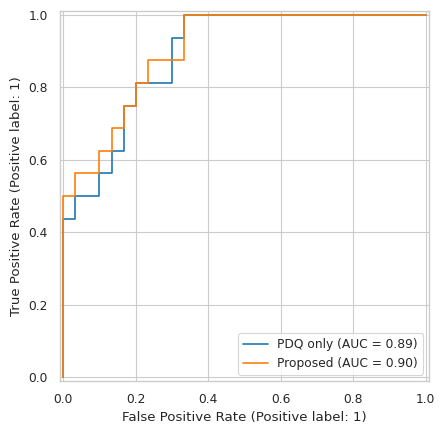

In [5]:
from sklearn.metrics import RocCurveDisplay
import statsmodels.formula.api as smf
import seaborn as sns

proposed = smf.logit("improvement ~ mahalanobis + pre_pdq", data=samples).fit()
pdq_only = smf.logit("improvement ~ pre_pdq", data=samples).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        samples["improvement"],
        pdq_only.predict(samples),
        name="PDQ only",
    )

    viz = RocCurveDisplay.from_predictions(
        samples["improvement"],
        proposed.predict(samples),
        name="Proposed",
        ax=viz.ax_,
    )

## Test post-predictions

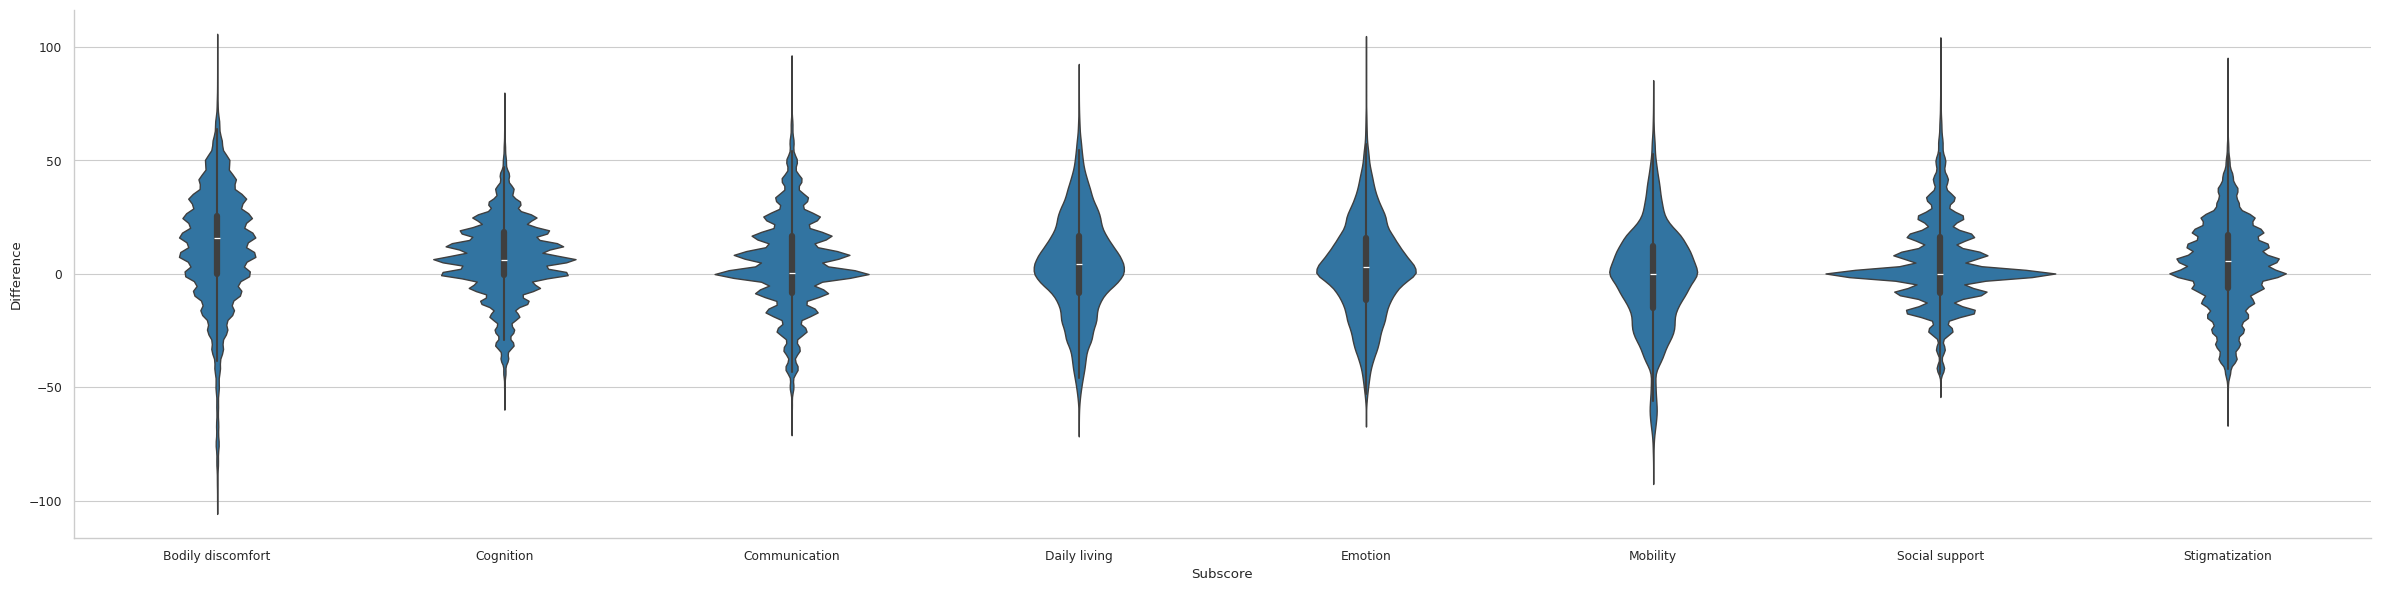

In [6]:
import seaborn as sns

relative_difference = pd.concat(
    [
        ((y_uke_predicted[y_uke_predicted["Subject"] == subject]) - data).assign(
            Subject=subject
        )
        for subject, data in y_uke.iterrows()
    ],
    ignore_index=True,
).melt(id_vars=["Subject", "Sample"], var_name="Subscore", value_name="Difference")

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    # sns.catplot(relative_difference[relative_difference["Subject"] == 0], x="Subscore", y="Difference", kind="box")
    sns.catplot(
        relative_difference,
        x="Subscore",
        y="Difference",
        kind="violin",
        height=6,
        aspect=4,
    )


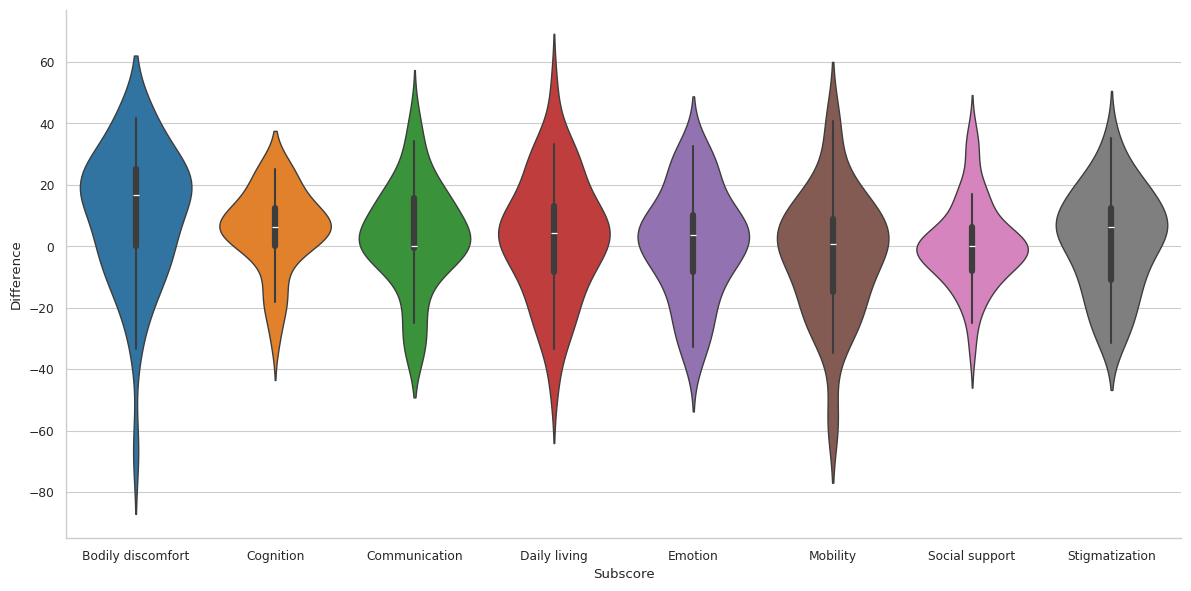

In [7]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        relative_difference.groupby(["Subscore", "Subject"]).median().reset_index(),
        x="Subscore",
        y="Difference",
        kind="violin",
        hue="Subscore",
        height=6,
        aspect=2,
        inner="box",
        #kind="box"
    )

In [8]:
from sklearn import decomposition

relative_differences_median = relative_difference.groupby(["Subscore", "Subject"]).median().reset_index().drop(columns=["Sample"]).pivot(index=["Subject"], columns=["Subscore"])

pca = decomposition.PCA(n_components=1)
relative_differences_median_projected = pca.fit_transform(relative_differences_median.to_numpy())

In [9]:
#sns.scatterplot(pd.DataFrame(relative_differences_median_projected, columns=["PC1", "PC2"], index=relative_differences_median.index), x="PC1", y="PC2")

## Predict given expected improvement

In [10]:
x_uke_pdq_total = X_uke[PDQ_COLUMNS].mean(axis=1)
diff = []
for subject, predicted_scores in y_uke_predicted.groupby("Subject"):
    mean_diff = pd.DataFrame(
        (x_uke_pdq_total[subject] - predicted_scores[PDQ_COLUMNS].median(axis=1)).rename(
            "Diff"
        )
    )
    mean_diff["Subject"] = subject
    diff.append(mean_diff)
diff = pd.concat(diff, ignore_index=True)

Optimization terminated successfully.
         Current function value: 0.355834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406781
         Iterations 6


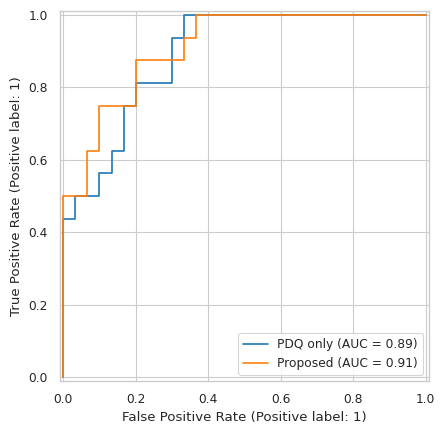

In [11]:
diff["pred_improvement"] = diff["Diff"] > 10.9

samples = pd.DataFrame(diff.groupby("Subject")["pred_improvement"].mean()).assign(
    improvement=((X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke.mean(axis=1)) > 10.9).astype(
        float
    ),
    pre_pdq=X_uke[PDQ_COLUMNS].mean(axis=1),
)

proposed = smf.logit("improvement ~ pred_improvement + pre_pdq", data=samples).fit()
pdq_only = smf.logit("improvement ~ pre_pdq", data=samples).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        samples["improvement"],
        pdq_only.predict(samples),
        name="PDQ only",
    )

    viz = RocCurveDisplay.from_predictions(
        samples["improvement"],
        proposed.predict(samples),
        name="Proposed",
        ax=viz.ax_,
    )

## Calculate difference to baseline

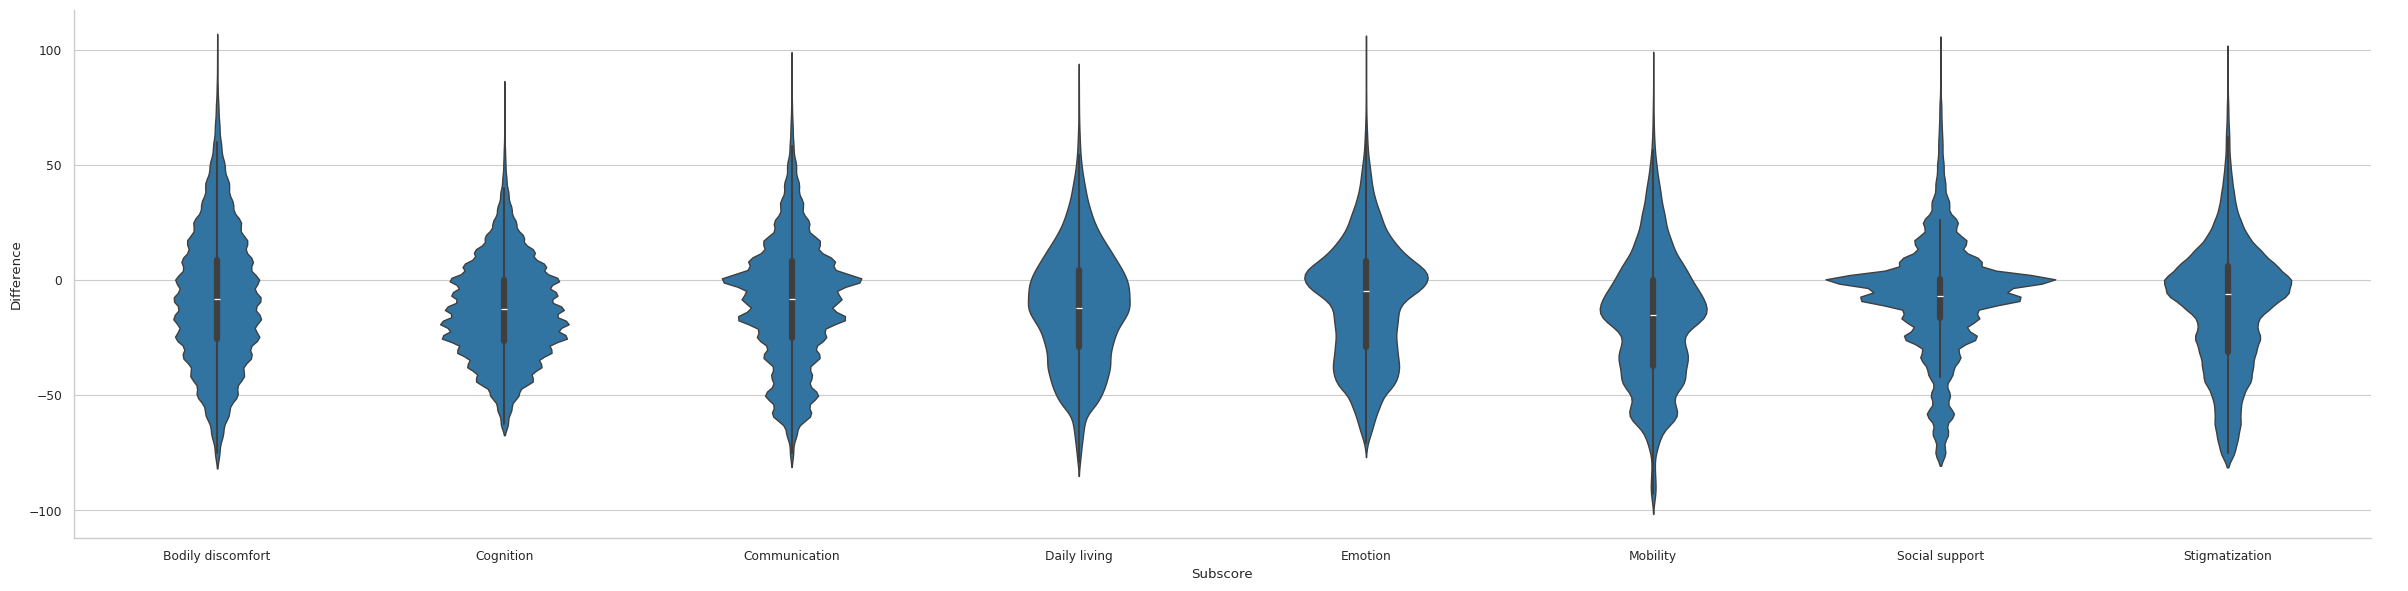

In [12]:
relative_difference_X_uke = pd.concat(
    [
        ((X_uke_predicted[X_uke_predicted["Subject"] == subject]) - data[PDQ_COLUMNS]).assign(
            Subject=subject
        )
        for subject, data in X_uke.iterrows()
    ],
    ignore_index=True,
).melt(id_vars=["Subject", "Sample"], var_name="Subscore", value_name="Difference")

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    # sns.catplot(relative_difference[relative_difference["Subject"] == 0], x="Subscore", y="Difference", kind="box")
    sns.catplot(
        relative_difference_X_uke,
        x="Subscore",
        y="Difference",
        kind="violin",
        height=6,
        aspect=4,
    )


In [13]:
median_diff_X_uke = relative_difference_X_uke.groupby(["Subscore", "Subject"]).mean().reset_index().drop(columns=["Sample"]).pivot(index=["Subject"], columns=["Subscore"], values="Difference")
median_diff_y_uke = relative_difference.groupby(["Subscore", "Subject"]).mean().reset_index().drop(columns=["Sample"]).pivot(index=["Subject"], columns=["Subscore"], values="Difference")

In [14]:
pre_post_comparison = median_diff_X_uke.reset_index().melt(id_vars=["Subject"], var_name="Subscore", value_name="Difference").set_index(["Subject", "Subscore"]).rename(columns={"Difference": "Pre"}).join(median_diff_y_uke.reset_index().melt(id_vars=["Subject"], var_name="Subscore", value_name="Difference").set_index(["Subject", "Subscore"]).rename(columns={"Difference": "Post"})).reset_index()

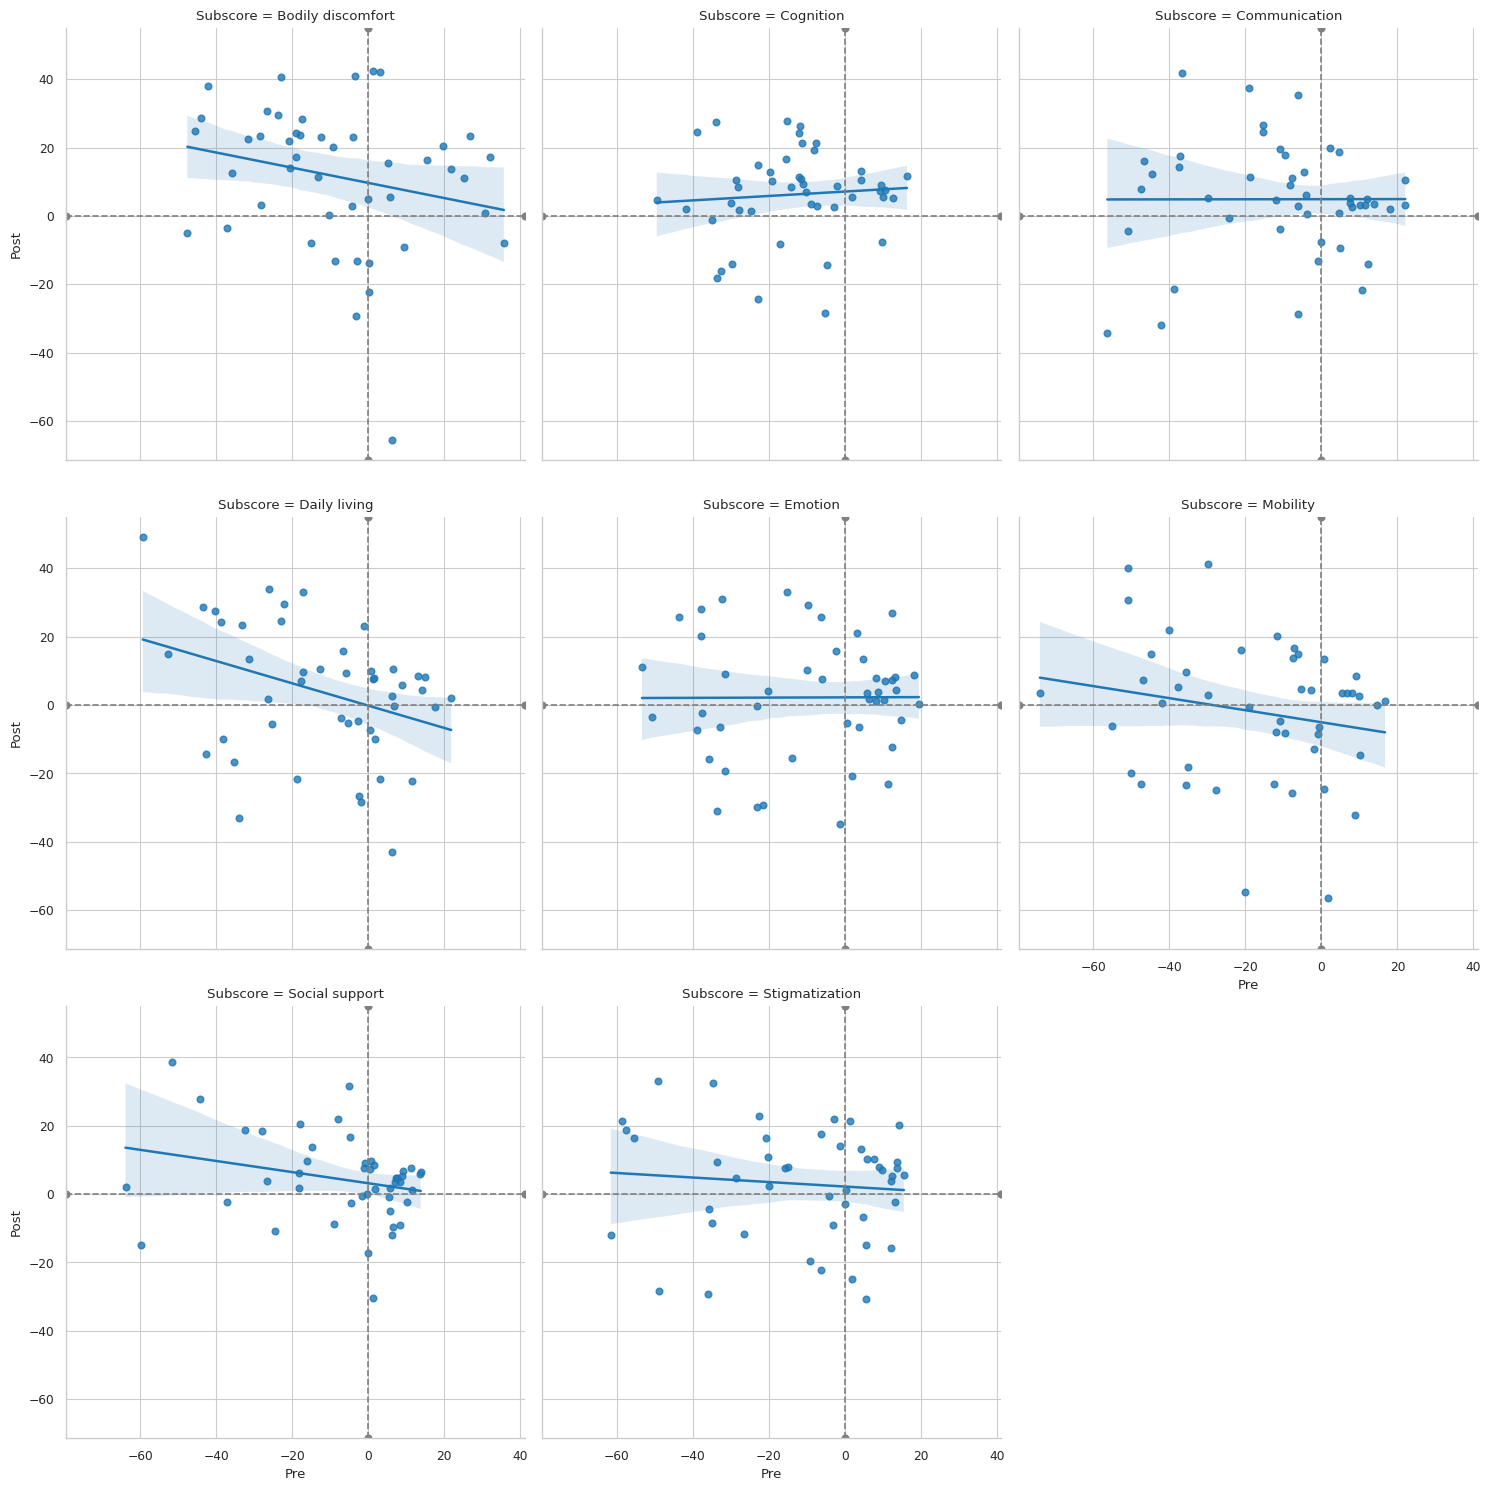

In [15]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    fig = sns.lmplot(pre_post_comparison, x="Pre", y="Post", col="Subscore", col_wrap=3, order=1, robust=False)
    fig.refline(x=0, y=0)

## Learn a model for the differences

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(median_diff_X_uke, median_diff_y_uke, test_size=0.10, random_state=SEED)

model_change = Treeffuser(seed=SEED)
model_change.fit(X_train.to_numpy().astype(np.float32), y_train.to_numpy().astype(np.float32))

y_test_hat = model_change.predict(X_test.to_numpy())
y_test_hat

Treeffuser(extra_lightgbm_params={}, seed=38)

## UMAP

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

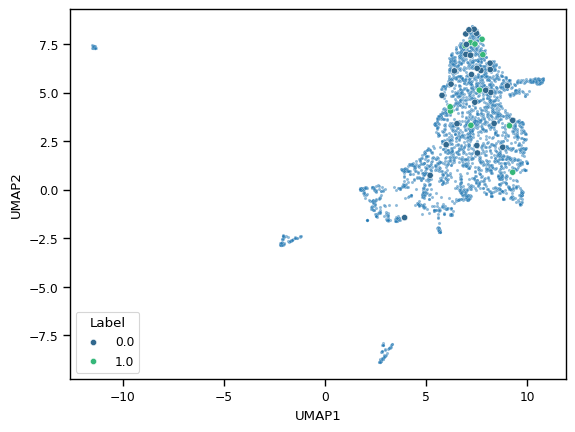

In [17]:
from umap import UMAP
import seaborn as sns

algorithm = UMAP(random_state=SEED, n_neighbors=30, min_dist=0.1, n_jobs=1)
y_amp_mapped = pd.DataFrame(
    algorithm.fit_transform(y_amp[PDQ_COLUMNS].dropna().to_numpy()),
    columns=["UMAP1", "UMAP2"],
)

X_uke_mapped = pd.DataFrame(
    algorithm.transform(X_uke[PDQ_COLUMNS].to_numpy()), columns=["UMAP1", "UMAP2"]
)
X_uke_mapped["Label"] = (
    (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) > 10.9
).astype(float)

ax = sns.scatterplot(data=y_amp_mapped, x="UMAP1", y="UMAP2", s=5, alpha=0.5)
sns.scatterplot(
    data=X_uke_mapped, x="UMAP1", y="UMAP2", ax=ax, s=20, hue="Label", palette="viridis"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

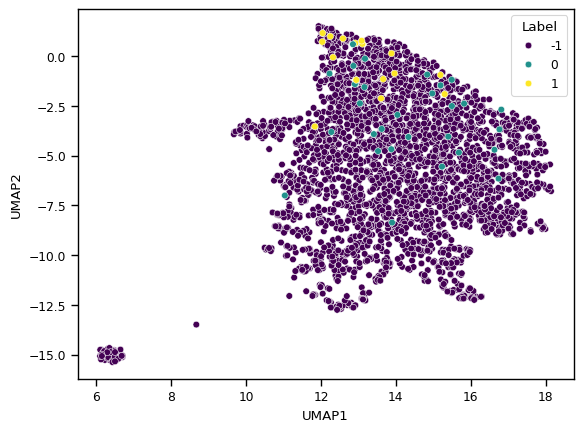

In [18]:
umap_X_amp = y_amp[PDQ_COLUMNS].dropna().reset_index(drop=True)
umap_X_amp["Label"] = -1

umap_X_uke = X_uke[PDQ_COLUMNS].copy()
umap_X_uke["Label"] = (
    (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1)) > 10.9
).astype(int)

umap_X = pd.concat((umap_X_amp, umap_X_uke), ignore_index=True)

algorithm = UMAP(random_state=SEED, n_neighbors=100, min_dist=0.5, n_jobs=1)
umap_X_mapped = algorithm.fit_transform(
    umap_X[PDQ_COLUMNS].to_numpy()
)  # , y=umap_X["Label"])

sns.scatterplot(
    data=pd.DataFrame(umap_X_mapped, columns=["UMAP1", "UMAP2"]).assign(
        Label=umap_X["Label"]
    ),
    x="UMAP1",
    y="UMAP2",
    hue="Label",
    palette="viridis",
)

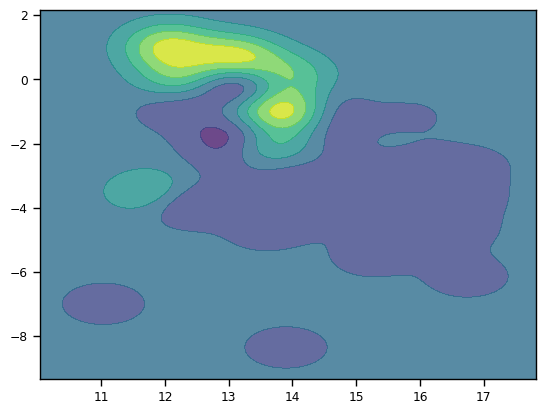

In [19]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

selection = umap_X["Label"] != -1
classifier = SVC(gamma=2, C=1, random_state=42)
classifier.fit(umap_X_mapped[selection], umap_X[umap_X["Label"] != -1]["Label"])

DecisionBoundaryDisplay.from_estimator(
    classifier, umap_X_mapped[selection], alpha=0.8, grid_resolution=500
)